**Part 4: Large Language Model**


In [1]:
import time, random, numpy as np, argparse, sys, re, os
from types import SimpleNamespace

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, f1_score, recall_score, accuracy_score

# change it with respect to the original model
from tokenizer import BertTokenizer
from bert import BertModel
from tqdm import tqdm
from classifier import BertSentClassifier

c:\Users\mi_ke\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


***4.1 The fine-tuned minBERT classifier***


Instantiate a BertSentClassifier model. Load the state dict from the checkpoint saved from the
previous question.

Load the best model checkpoint from the previous question. and instantiate a BertSentClassifier

In [38]:
device = torch.device(
    'cpu')
filepath = 'flexible-10-1e-05.pt'

saved = torch.load(filepath)
config = saved['model_config']
model = BertSentClassifier(config)
model.load_state_dict(saved['model'])
print('model loaded')
print('model config: ', config)
model = model.to(device)

model loaded
model config:  namespace(data_dir='.', hidden_dropout_prob=0.3, hidden_size=768, num_labels=2, option='flexible')


Specifiy the batch of sentences

- Very positive: The movie was a masterpiece with a brilliant storyline and exceptional performances by the entire cast.

- Less positive: The film was enjoyable overall, but some of the dialogues felt a bit clichéd.

- Slightly negative: The plot was somewhat predictable, and it failed to capture my interest throughout the movie.

- Very negative: It was a terrible movie with poor acting, a weak script, and subpar visual effects that made it unbearable to watch.

- Off-the-topic: I had a delicious sandwich for lunch from the new café around the corner.

In [39]:
sentences = [
    "The movie was a masterpiece with a brilliant storyline and exceptional performances by the entire cast.",
    "The film was okay overall, but the pacing was a bit slow it some parts. It could have been better if it was a bit shorter.",
    "The plot was somewhat predictable, and it failed to capture my interest throughout the movie, but the characters has some interesting personalities.",
    "It was a terrible movie with poor acting, a weak script, and subpar visual effects that made it unbearable to watch.",
    "I had a delicious sandwich for lunch from the new café around the corner."
]

In [40]:
def pad_data(data):
    sents = [x[0] for x in data]
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    encoding = tokenizer(sents, return_tensors='pt', padding=True, truncation=True)
    token_ids = torch.LongTensor(encoding['input_ids'])
    attention_mask = torch.LongTensor(encoding['attention_mask'])
    token_type_ids = torch.LongTensor(encoding['token_type_ids'])

    return token_ids, token_type_ids, attention_mask, sents


# create the data which is a list of (sentence, label, token for the labels)
def create_data(sentences):
    # specify the tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    data = []

    for line in sentences:
        sent = line.lower().strip()
        tokens = tokenizer.tokenize("[CLS] " + sent + " [SEP]")
        data.append((sent,tokens))
        
    return data

In [41]:
data = create_data(sentences=sentences)

token_ids, type_ids, mask, sents = pad_data(data)

model_output = model(token_ids, mask)
model_output = model_output.detach().cpu().numpy()


In [47]:
for index, logits in enumerate(model_output):
    # Exponentiate the logits to get the probabilities
    prob = np.exp(logits)/ np.sum(np.exp(logits))
    positive_prob = prob[1]
    negative_prob = prob[0]
    label = None
    if positive_prob >= negative_prob:
        label = 'Positive'
    else:
        label = 'Negative'

    print(sentences[index] + ' --- ' + 'Class Label: ' + label )
    print('Positive Probability: ' + str(positive_prob))
    print('Negative Probability: ' + str(negative_prob))
    print('---------------------------------------')

The movie was a masterpiece with a brilliant storyline and exceptional performances by the entire cast. --- Class Label: Positive
Positive Probability: 0.9933058
Negative Probability: 0.006694194
---------------------------------------
The film was okay overall, but the pacing was a bit slow it some parts. It could have been better if it was a bit shorter. --- Class Label: Positive
Positive Probability: 0.92735577
Negative Probability: 0.07264426
---------------------------------------
The plot was somewhat predictable, and it failed to capture my interest throughout the movie, but the characters has some interesting personalities. --- Class Label: Negative
Positive Probability: 0.004681286
Negative Probability: 0.9953188
---------------------------------------
It was a terrible movie with poor acting, a weak script, and subpar visual effects that made it unbearable to watch. --- Class Label: Negative
Positive Probability: 0.00055427477
Negative Probability: 0.9994457
-----------------

Comments:

The model performs relatively well on the task of capturing the polarity of the sentences. It correctly classifies the sentence "The movie was a masterpiece with a brilliant storyline and exceptional performances by the entire cast" with strong postive probability of 0.993, while the sentence "It was a terrible movie with poor acting, a weak script, and subpar visual effects that made it unbearable to watch" was correctly given a negative probability of 0.999.

As for the fine-grained polarity, the model's prediction mostly aligns with the sentiment of the the sentences. For the slightly positive and negative sentences, the model struggles to assign the proper probabilities because of the mixed sentiment nature. The slightly positive sentence has a positive probability of 0.927, which is slightly lower than the very postive sentence mostly because it contains words such as " a bit slow", "could have been better". The slightly negative senetence
is only slightly less negative with probability of 0.995, could be because the model giving more weight to the negative aspects mentioned in the sentence (e.g., "predictable" and "failed to capture my interest). They do both align with the fine-grained polarity expected values.

The off-topic sentence was classified as positive with probability of 0.724 which is reasonable considering the sentiment of the sentence e.g(delicious)even though it's unrelated to the movie domain.

***4.2 A general-purpose multi-task learner***

Use huggingface’s Transformers library to load a AutoModelForCausalLM (previously this was also called AutoModelWithLMHead) model. To allow comparison against the previous question, let’s load the bert-base-uncased model.

In [50]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained("bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

c:\Users\mi_ke\AppData\Local\Programs\Python\Python38\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mi_ke\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`
Some weights of the model checkpoint at ber

Prepare the sentences to be inputted to the CasualLM model

In [51]:
sentences = [
    "The movie was a masterpiece with a brilliant storyline and exceptional performances by the entire cast.",
    "The film was okay overall, but the pacing was a bit slow it some parts. It could have been better if it was a bit shorter.",
    "The plot was somewhat predictable, and it failed to capture my interest throughout the movie, but the characters has some interesting personalities.",
    "It was a terrible movie with poor acting, a weak script, and subpar visual effects that made it unbearable to watch.",
    "I had a delicious sandwich for lunch from the new café around the corner."
]
CausalLM_sentences = []
for sentence in sentences:
    CausalLM_sentences.append(sentence + " This movie review is")

CausalLM_sentences.append(sentences[-1] + " This sentence is")

In [86]:
for sentence in CausalLM_sentences:
    input_ids = tokenizer.encode(sentence, return_tensors='pt')
    outputs = model(input_ids, labels=input_ids)

    probs = outputs.logits.softmax(dim=-1)
    pos_prob = probs[0, -1, tokenizer.convert_tokens_to_ids("positive")].item()
    neg_prob = probs[0, -1, tokenizer.convert_tokens_to_ids("negative")].item()
    if pos_prob >= neg_prob:
        label = 'positive'
    else:
        label = 'negative'
    print('Sentence: ' + sentence + ' ' + label)
    print('Probability of the next word being "positive": ', str(pos_prob))
    print('Probability of the next word being "negative": ', str(neg_prob))
    
    print('---------------------------------------')


Sentence: The movie was a masterpiece with a brilliant storyline and exceptional performances by the entire cast. This movie review is negative
Probability of the next word being "positive":  1.8164472148640698e-09
Probability of the next word being "negative":  6.8217440585272016e-09
---------------------------------------
Sentence: The film was okay overall, but the pacing was a bit slow it some parts. It could have been better if it was a bit shorter. This movie review is negative
Probability of the next word being "positive":  3.055683635011519e-07
Probability of the next word being "negative":  3.890874609169259e-07
---------------------------------------
Sentence: The plot was somewhat predictable, and it failed to capture my interest throughout the movie, but the characters has some interesting personalities. This movie review is negative
Probability of the next word being "positive":  4.4362411522058665e-09
Probability of the next word being "negative":  2.7725267415235066e-08


 Mask [SEP] token to improve model performance

In [89]:
for sentence in CausalLM_sentences:
    
    input_ids = tokenizer.encode(sentence, return_tensors='pt')
    
    input_ids_list = input_ids.tolist()[0]
    # Create the attention mask with 0s for [SEP] tokens and 1s for all other tokens
    attention_mask_list = [0 if token_id == tokenizer.sep_token_id else 1 for token_id in input_ids_list]

    # Convert the attention_mask list to a tensor
    attention_mask = torch.tensor([attention_mask_list], dtype=torch.long)
    
    outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)

    probs = outputs.logits.softmax(dim=-1)
    pos_prob = probs[0, -1, tokenizer.convert_tokens_to_ids("positive")].item()
    neg_prob = probs[0, -1, tokenizer.convert_tokens_to_ids("negative")].item()
    if pos_prob >= neg_prob:
        label = 'positive'
    else:
        label = 'negative'
    print('Sentence: ' + sentence + ' ' + label)
    print('Probability of the next word being "positive": ', str(pos_prob))
    print('Probability of the next word being "negative": ', str(neg_prob))
    
    print('---------------------------------------')


Sentence: The movie was a masterpiece with a brilliant storyline and exceptional performances by the entire cast. This movie review is positive
Probability of the next word being "positive":  3.7384117604233325e-05
Probability of the next word being "negative":  1.3341978956304956e-05
---------------------------------------
Sentence: The film was okay overall, but the pacing was a bit slow it some parts. It could have been better if it was a bit shorter. This movie review is positive
Probability of the next word being "positive":  1.2243726814631373e-06
Probability of the next word being "negative":  1.480306650591956e-07
---------------------------------------
Sentence: The plot was somewhat predictable, and it failed to capture my interest throughout the movie, but the characters has some interesting personalities. This movie review is positive
Probability of the next word being "positive":  2.0652452803915367e-05
Probability of the next word being "negative":  1.5916912161628716e-06

Comments:

Before masking the [SEP] token, the AutoModelForCausalLM's performance is quite poor, since it is only querying the probability at the last token which [SEP].
After masking the [SEP] token, the model is still not as good as the pretrained BERT model but does capture the polarity to some extent
Since it is not trained to perform sentiment analysir nor trained on any movie review dataset, it is expected to have a poor performance when querying the probability of the postive or negtaive tokens, which indicates the polarity of the sentence.

In all sentences,the LM predicts probabilities of positive and negative with very low values which indicates model's low confidence in the prediction, however it does give a slightly higher positive probability for very postive and slightly postive sentences and a slightly negative probability for very negative sentence, which shows
some abilities to recognize the polarities of the sentences.

The changing the appendix to e.g., “This sentence is”  does not improve the out-of-domain generalization ability as shown above with the similar positive probabilities.

***4.3 A large-scale multi-task learner***


choose an LLM and use it in the generation mode (i.e., let it continue writing given a prompt). Design a form of your choice (e.g., S+“This movie review is”, or other forms) that allows the LLM to output its prediction of whether the 5 sentences you wrote are positive or not.

For 4.3, I chose to use GPT-3 via its playground. Screenshots are provided below which shows the prediction of the 5 sentences.

Prompt used: Sentence + "This movie review is (positive/negative)?"

Generation hyperparameters:

Temperature: 0.5 -> This controls the randomness and creativity of the reponse. I chose 0.5 because too much creativity could make the 
classification not accurate but too deterministic would limit model's performance

Max-Token: 50 -> The prompt above formulates a one word response so I chose to limit the number of words generated to improve performance.

Top-p : 0.8 -> This controls the diversity, I chose 0.8 to keep the word choice relatively diverse.

Show-Probability: Full-Specturm -> So I can see the probability of each token, to compare fine-grained polarity.




Very Positive Sentence:

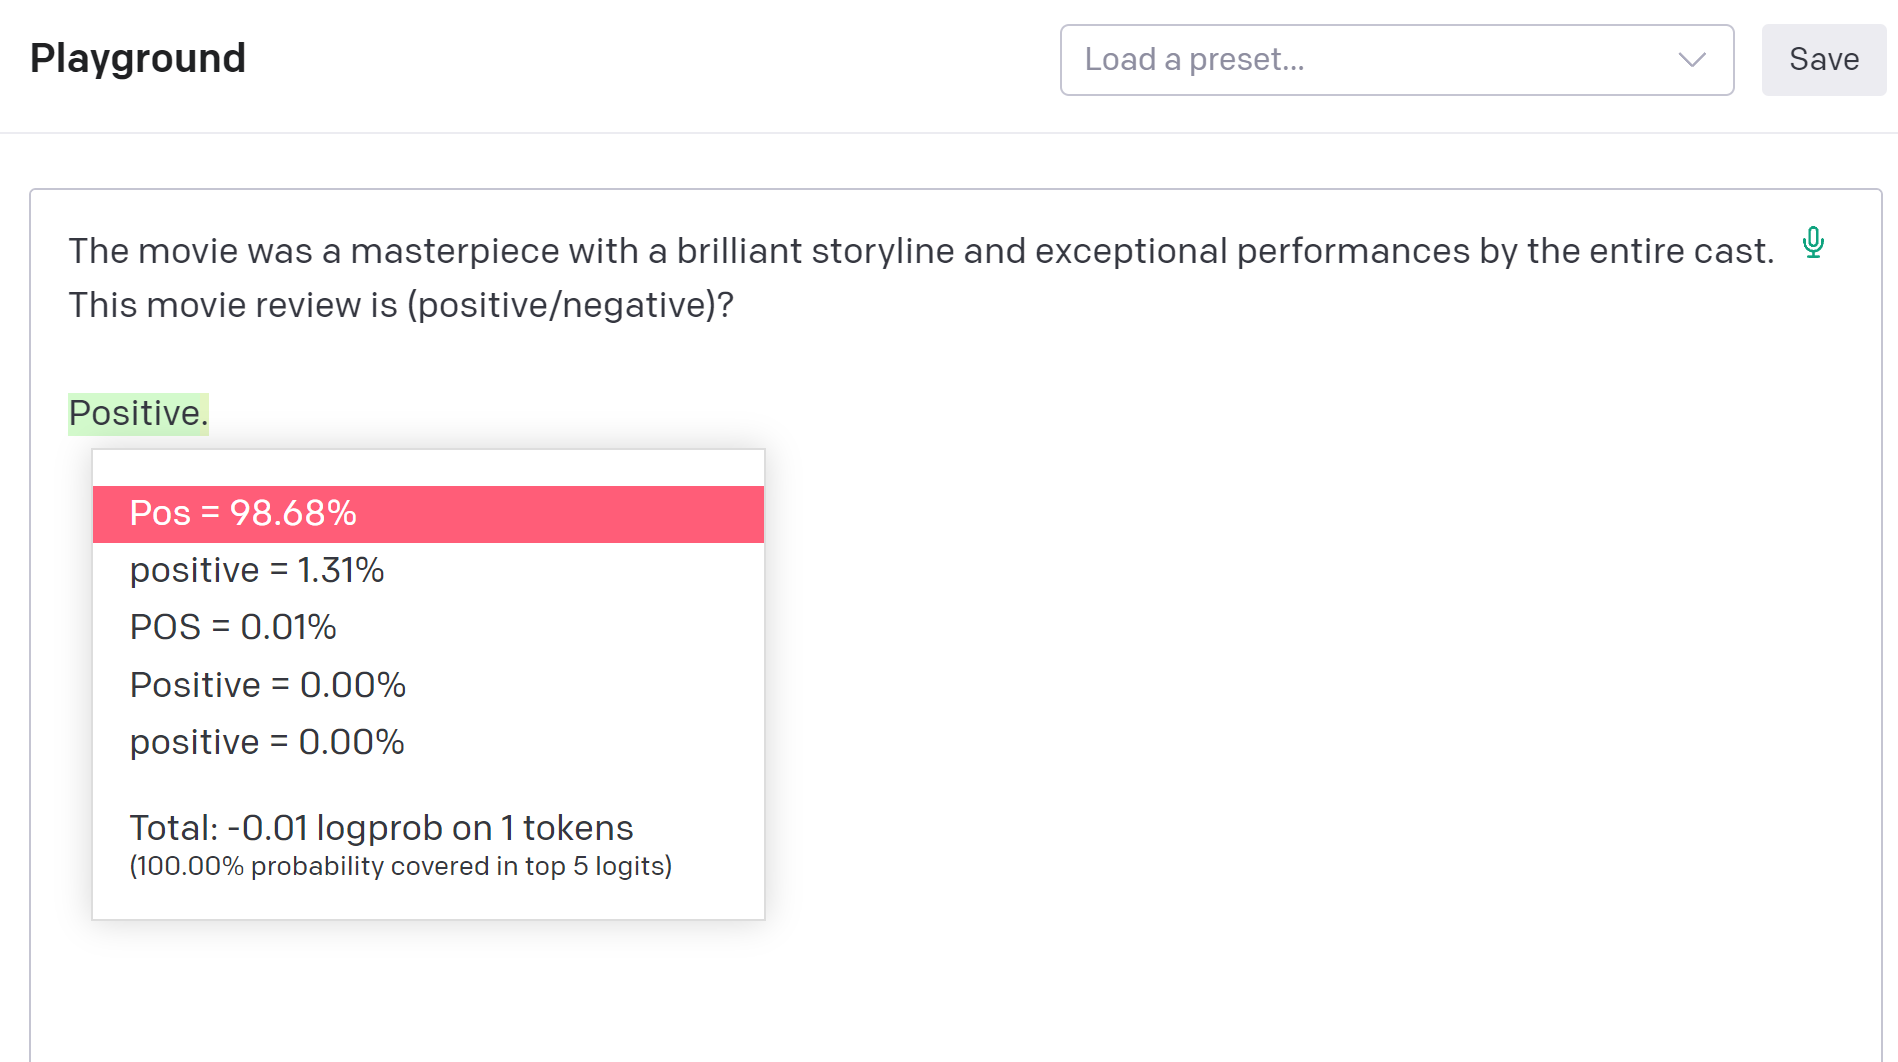

Slightly Positive Sentence:
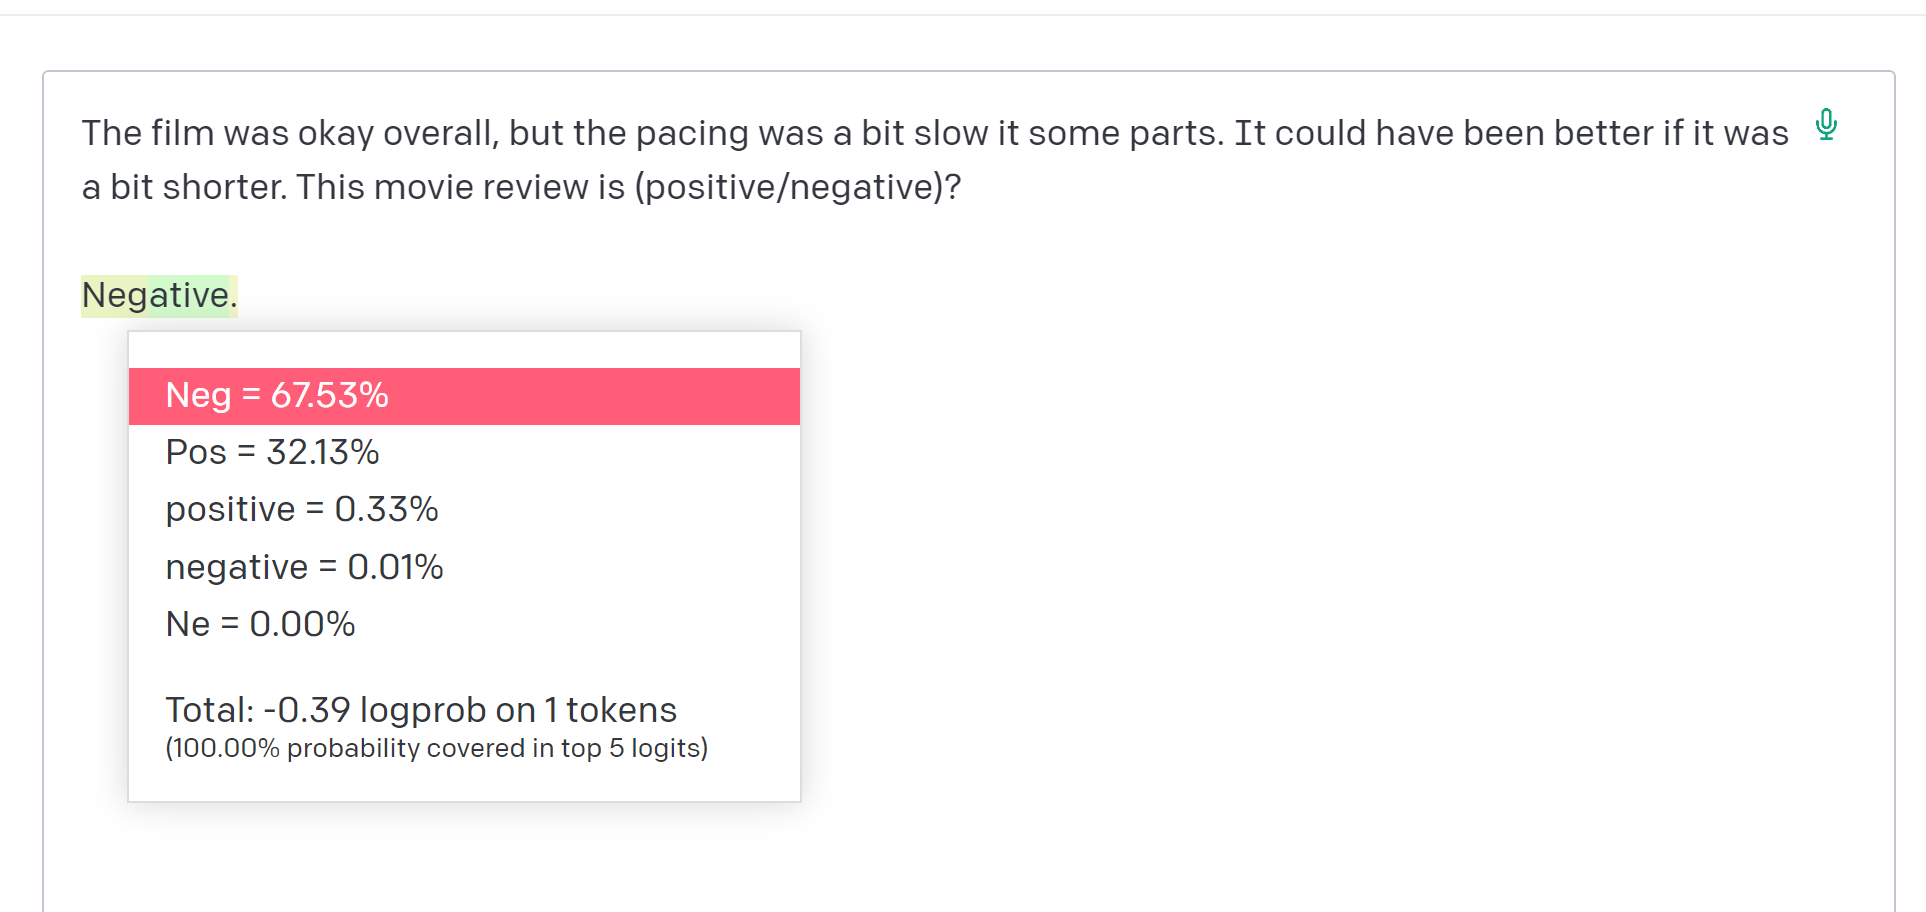

Slightly Negative Sentence:
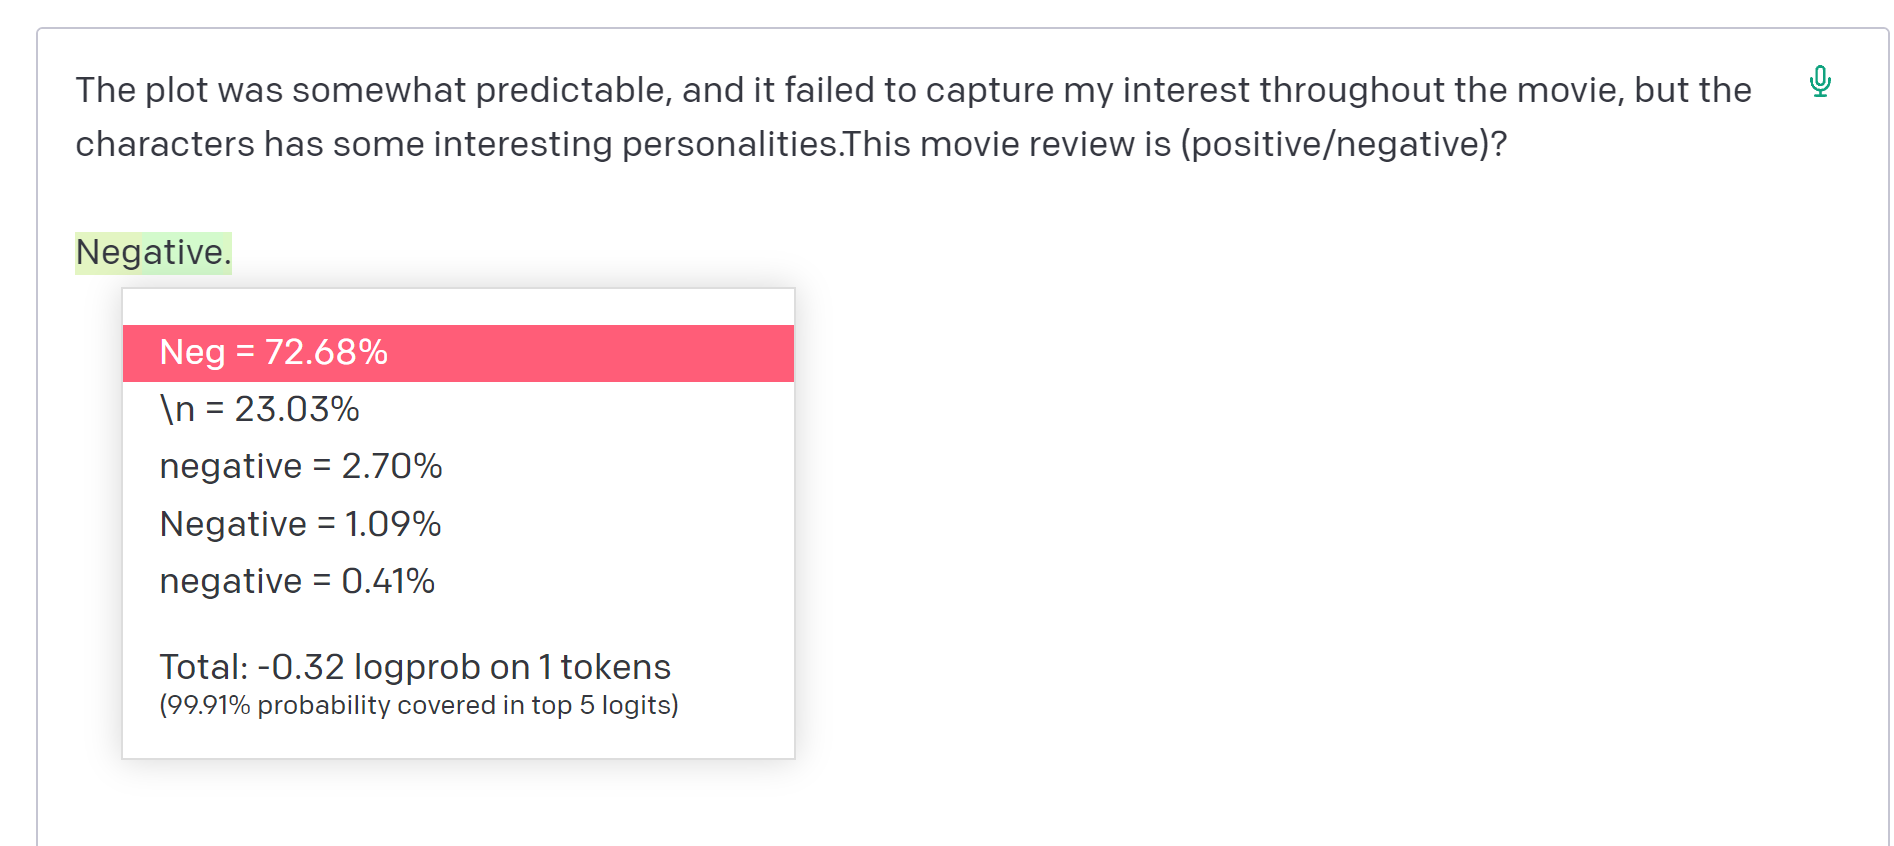

Very Negative Sentence:
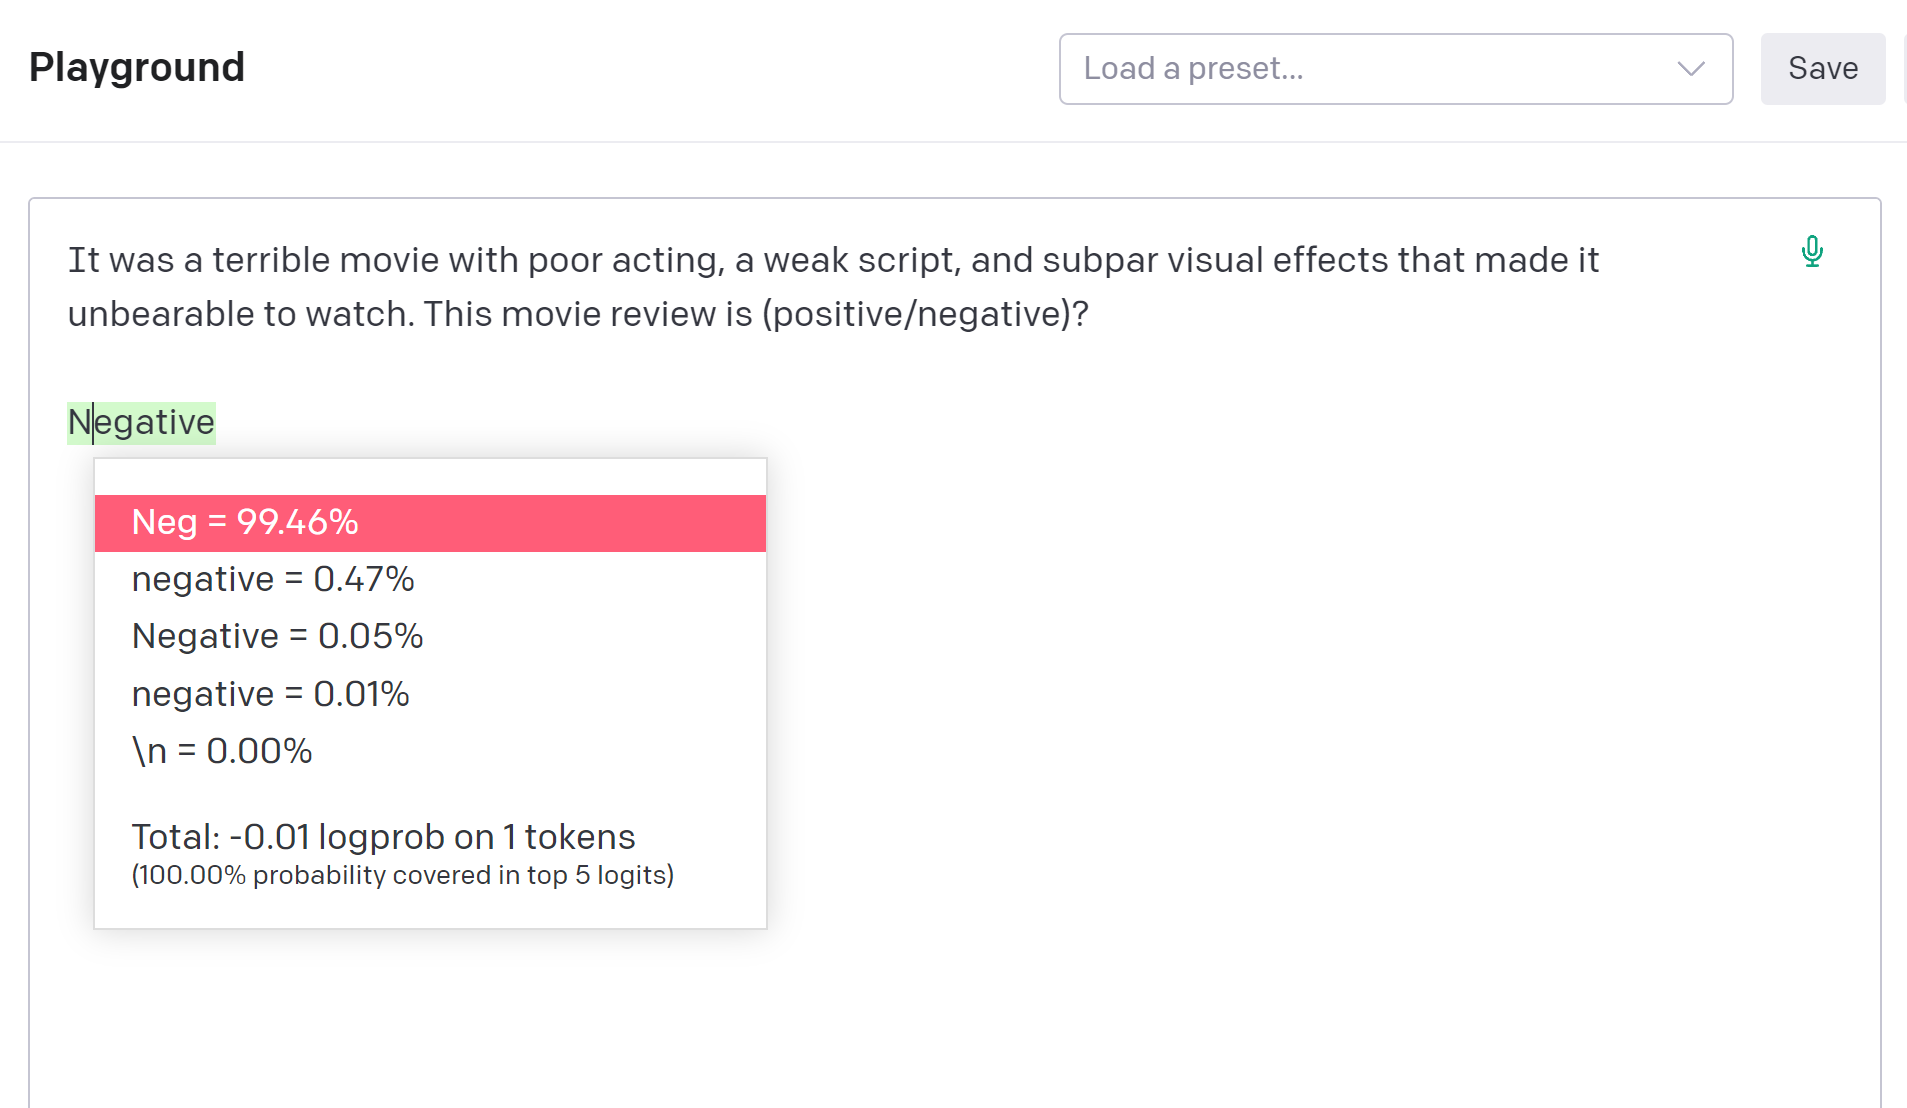

Off Topic Sentence:
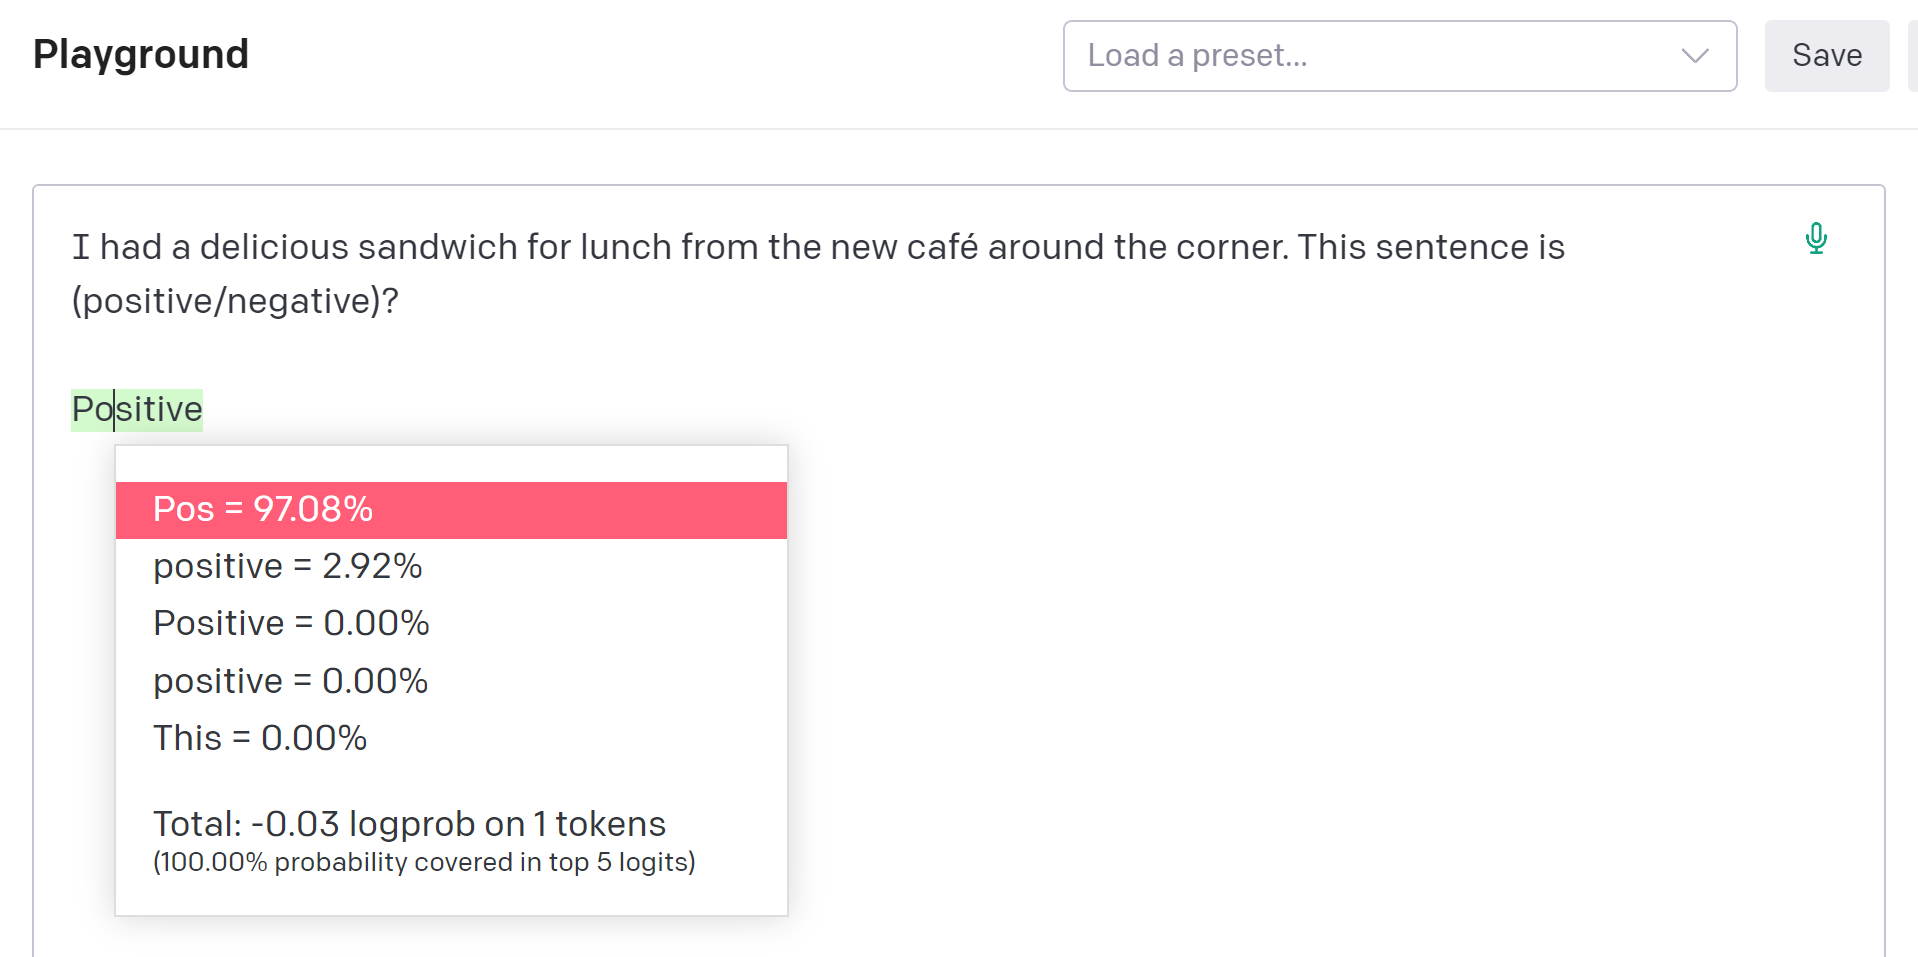

Comments:

GPT-3 shows much better capabilities than the AutoModelForCausalLM model and performs almost the same with the pre-trained BERT model in section 4.1. However it does misclassify the less positive sentence, showing negative probaility of 67.5% and positive probaility of 32.5%, which may be because the model weights negative sentiment more.
In general LLM like GPT3 would have better performance than smaller models due to its ability to capture and understand more complex linguistic structures and nuances on unseen tasks. However, smaller models that are pretrained on specific task like the one in section 4.1 could definetely outperform LLM on that specific task.